# Using Weakly Aligned Score–Audio Pairs to Train Deep Chroma Models for Cross-Modal Music Retrieval

This notebook accompanies the following paper:

<ul>    
<li><span style="color:black">
Frank Zalkow and Meinard Müller: <strong>Using Weakly Aligned Score–Audio Pairs to Train Deep Chroma Models for Cross-Modal Music Retrieval.</strong> In Proceedings of the International Society for Music Information Retrieval Conference, Montréal, Canada, 2020. <a class="btn btn-default btn-xs" href="https://www.audiolabs-erlangen.de/resources/MIR/2020-ISMIR-ctc-chroma/reference_paper.bib">Bibtex</a> <a class="btn btn-default btn-xs" href="https://www.audiolabs-erlangen.de/resources/MIR/2020-ISMIR-ctc-chroma">Website</a>
</ul>  
    
The paper describes an approach to train a neural network with weakly aligned score–audio pairs to compute an enhanced chroma representation. See more details in the paper.
    
The notebook shows how to apply the neural network model described in the paper to compute the enhanced chroma representation. The repository contains several model variants, due to different training and validation splits. Furthermore, the repository also contains two public domain audio excerpts. The following table shows both audio excerpts.
    
<table class="table table-striped">
  <thead>
    <tr>
      <th>Composer</th>
      <th>Work</th>
      <th>Performer</th>
      <th>Description</th>
      <th>Audio</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Beethoven</td>
      <td>Symphony no. 5, op. 67</td>
      <td>Davis High School Symphony Orchestra</td>
      <td>First movement, first theme</td>
      <td>
        <audio controls style="width:100px;" src="audio/Beethoven_Op002-2-01_Pitman.wav" type="audio/wav"></audio>
      </td>
    </tr>
    <tr>
      <td>Beethoven</td>
      <td>Piano Sonata no. 2, op. 2 no. 2</td>
      <td>Paul Pitman</td>
      <td>First movement, second theme</td>
      <td>
        <audio controls style="width:100px;" src="audio/Beethoven_Op067-01_DavidHighSchool.wav" type="audio/wav"></audio>
      </td>
    </tr>
  </tbody>
</table>
    
We start by importing some Python packages and setting some paths. You may change the variables `cur_model_id` and `cur_audio_path` to select a different model variant or a different audio file.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import librosa
import IPython.display as ipd

import ctc_chroma


model_ids = ['train123valid4',
             'train234valid5',
             'train345valid1',
             'train451valid2',
             'train512valid3',
             'train1234valid5',
             'train2345valid1',
             'train3451valid2',
             'train4512valid3',
             'train5123valid4']

audio_paths = ['audio/Beethoven_Op002-2-01_Pitman.wav',
               'audio/Beethoven_Op067-01_DavidHighSchool.wav']

cur_model_id = model_ids[1]
cur_audio_path = audio_paths[1]

Next, we load the model and its weights, compute the input representation (HCQT), and apply the model.
To compare the enhanced chroma representation, we also compute a baseline chroma representation based on the CQT representation that is part of the network's input.

In [2]:
model = ctc_chroma.models.get_model(cur_model_id)

hcqt, times, freqs = ctc_chroma.features.compute_hcqt_median(cur_audio_path, feature_rate=25)
hcqt_norm = librosa.util.normalize(hcqt.T, norm=2, fill=True, axis=1)

probabilities_ctc = model.predict(hcqt_norm[np.newaxis, :, :, :])[0, :, :].T
chroma_ctc = librosa.util.normalize(probabilities_ctc[:-1, :], norm=2, fill=True, axis=0)

bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length = ctc_chroma.features.get_hcqt_params()
chroma_cqt = librosa.feature.chroma_cqt(C=hcqt_norm[:, :, 1].T, fmin=fmin, bins_per_octave=bins_per_octave)

Finally, the next code cell presents an audio player for the music recording and visualizes several matrices.
First, we display a slice of the HCQT representation (corresponding to the fundamental $h=1$).
Second, we display a chroma representation based on this slice of the HCQT.
This is not used for the neural network but is visualized for the sake of comparison.
Third, we display the output of the network.
Forth, we visualize the enhanced chroma representation computed from the output of the network.

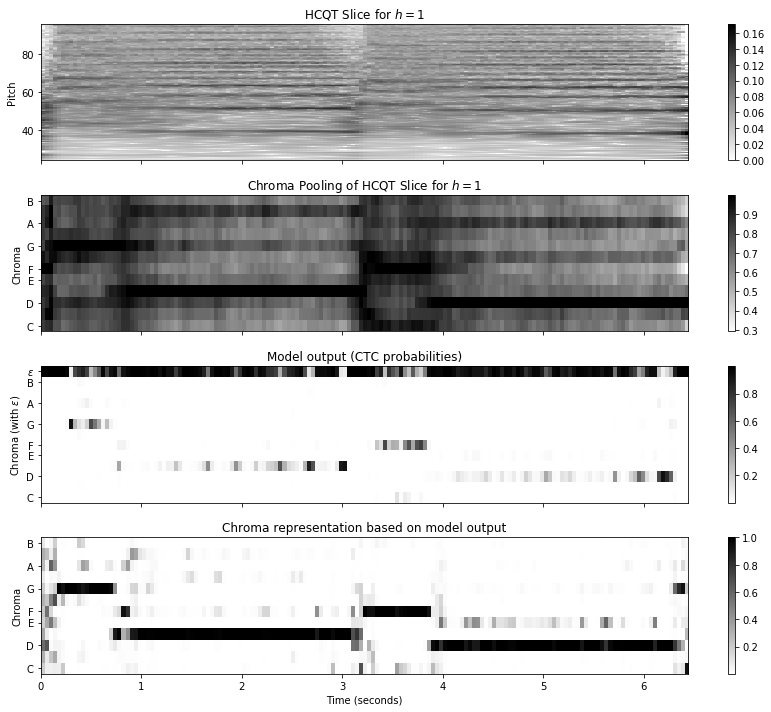

In [3]:
def subplot_imshow(ax, x, title, ymin, ymax, ylabel, yticks=None, yticklabels=None):
    ax.set_title(title)
    im = ax.imshow(x, aspect='auto', origin='lower', cmap='gray_r',
                   extent=[0, x.shape[1] / 25, ymin, ymax])
    ax.set_ylabel(ylabel)
    plt.colorbar(im, ax=ax)
    
    if yticks is not None and yticklabels is not None:
        ax.set_yticks(np.array(yticks) + 0.5)
        ax.set_yticklabels(yticklabels.split())
        

ipd.display(ipd.Audio(filename=cur_audio_path))

fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

midi_min = librosa.hz_to_midi(fmin)
subplot_imshow(ax[0], hcqt_norm[:, :, 1].T, 'HCQT Slice for $h=1$', midi_min, midi_min + n_octaves * 12,
               'Pitch')

subplot_imshow(ax[1], chroma_cqt, 'Chroma Pooling of HCQT Slice for $h=1$', 0, 12,
               'Chroma', [0, 2, 4, 5, 7, 9, 11], 'C D E F G A B')
    
subplot_imshow(ax[2], probabilities_ctc, 'Model output (CTC probabilities)', 0, 13,
               'Chroma (with $\\epsilon$)', [0, 2, 4, 5, 7, 9, 11, 12], 'C D E F G A B $\\epsilon$')

subplot_imshow(ax[3], chroma_ctc, 'Chroma representation based on model output', 0, 12,
               'Chroma', [0, 2, 4, 5, 7, 9, 11], 'C D E F G A B')

ax[3].set_xlabel('Time (seconds)')
plt.tight_layout()

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow/">Frank Zalkow</a> and <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div>